In [16]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/all_currencies.csv")

# Show first 5 rows
df.head()


,Unnamed: 0,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
0,0,2015-11-12,$$$,0.000013,0.000017,0.000013,0.000017,142.0,NaN
1,1,2015-11-13,$$$,0.000017,0.000033,0.000016,0.000024,85.0,NaN
2,2,2015-11-14,$$$,0.000024,0.000053,0.000023,0.000030,131.0,NaN
3,3,2015-11-15,$$$,0.000030,0.000063,0.000022,0.000035,132.0,NaN
4,4,2015-11-16,$$$,0.000035,0.000046,0.000032,0.000036,280.0,NaN


In [17]:
# --- Step 3: Data Cleaning ---

# 1. Remove unwanted unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# 2. Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 3. Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# 4. Check for missing values
print("Missing values in each column:")
print(df.isna().sum())

# Show cleaned dataset
df.head()


Missing values in each column:
Date              0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume         5756
Market Cap    84485
dtype: int64


,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
0,2013-04-28,NMC,1.100000,1.120000,1.080000,1.110000,NaN,5969080.0
1,2013-04-28,PPC,0.386958,0.404659,0.376287,0.386525,NaN,7255800.0
2,2013-04-28,TRC,0.650793,0.654064,0.634409,0.646892,NaN,1510150.0
3,2013-04-28,LTC,4.300000,4.400000,4.180000,4.350000,NaN,73773400.0
4,2013-04-28,NVC,4.220000,4.250000,4.040000,4.250000,NaN,1155160.0


In [18]:
# Check unique crypto symbols
df['Symbol'].unique()

# Choose your symbol (change this after you see the output)
symbol = "BTC"   # or "LTC" or any other

# Filter only that symbol
df_symbol = df[df['Symbol'] == symbol].copy()

# Sort again just to be safe
df_symbol = df_symbol.sort_values('Date').reset_index(drop=True)

df_symbol.head()

# Forward-fill price columns (important for time-series modeling)
price_cols = ['Open', 'High', 'Low', 'Close']
for col in price_cols:
    df_symbol[col] = df_symbol[col].fillna(method='ffill')

# Fill missing Volume with 0 (common for older BTC data)
df_symbol['Volume'] = df_symbol['Volume'].fillna(0)

# Fill Market Cap missing values
df_symbol['Market Cap'] = df_symbol['Market Cap'].fillna(method='ffill')

# Check missing values again
df_symbol.isna().sum()




/tmp/ipykernel_1833/1363065946.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_symbol[col] = df_symbol[col].fillna(method='ffill')
/tmp/ipykernel_1833/1363065946.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_symbol['Market Cap'] = df_symbol['Market Cap'].fillna(method='ffill')


Date          0
Symbol        0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

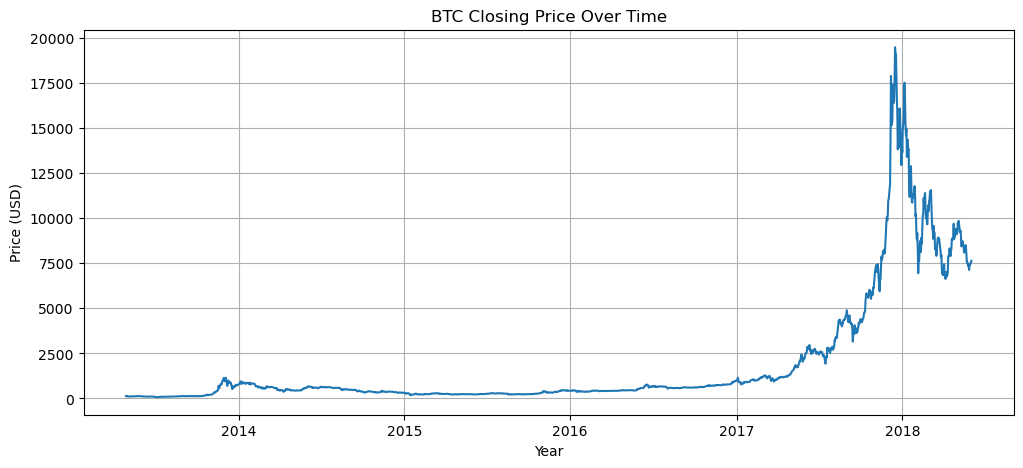

count     1862.000000
mean      1877.180569
std       3316.299695
min         68.430000
25%        285.240000
50%        563.155000
75%       1048.822500
max      19497.400000
Name: Close, dtype: float64

In [6]:
import matplotlib.pyplot as plt

# Step 5.1 — Set Date as index
df_ts = df_symbol.set_index("Date")

# Step 5.2 — Select the Close price series only
close_ts = df_ts["Close"]

# Step 5.3 — Plot the closing price
plt.figure(figsize=(12,5))
plt.plot(close_ts)
plt.title("BTC Closing Price Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

# Show summary
close_ts.describe()


/tmp/ipykernel_1833/1806196857.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_ts = close_ts.asfreq('D').fillna(method='ffill')


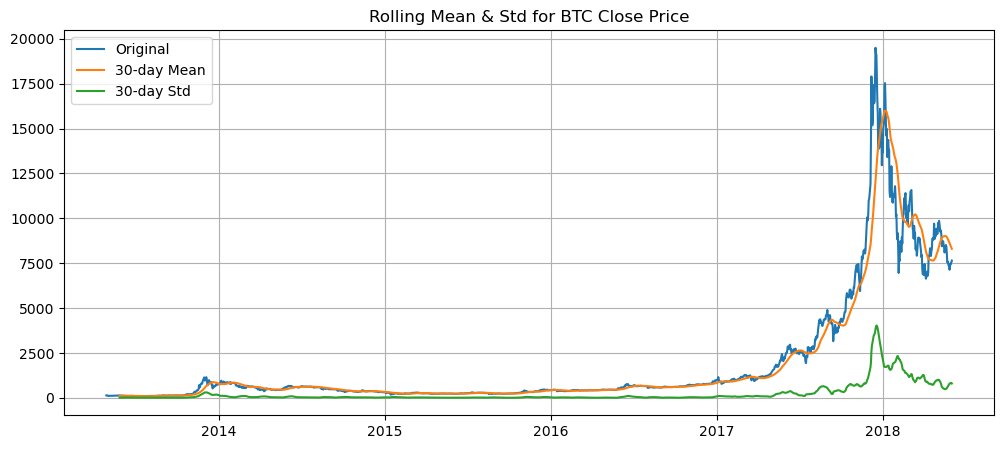

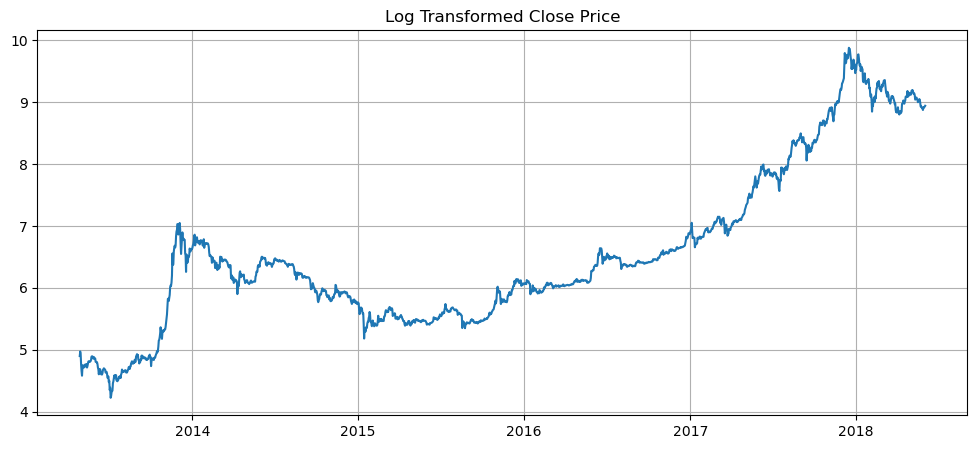

ADF Test on Original Series
ADF Statistic: -1.8094633761219048
p-value: 0.37577361483390087
----------------------------------------
KPSS Test on Original Series
KPSS Statistic: 3.122781339487872
p-value: 0.01
----------------------------------------


/tmp/ipykernel_1833/1806196857.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, lags, crit = kpss(close_ts.dropna(), regression='c')


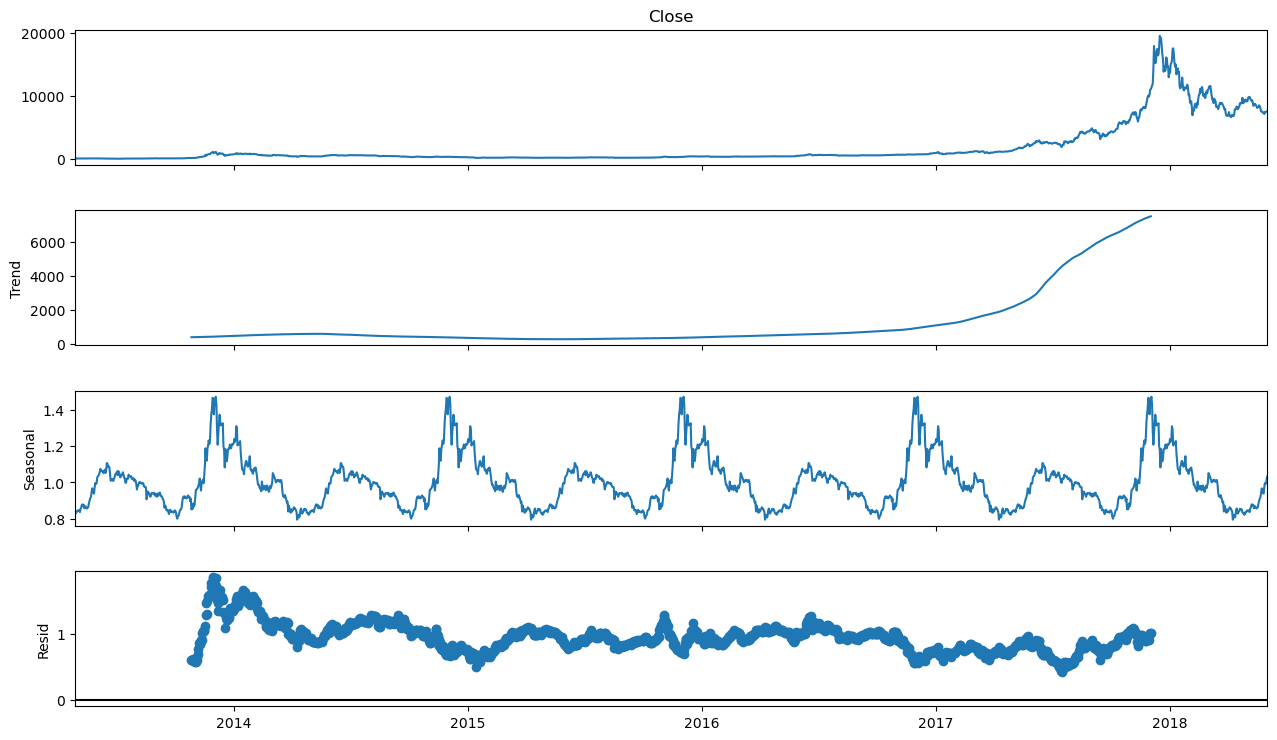

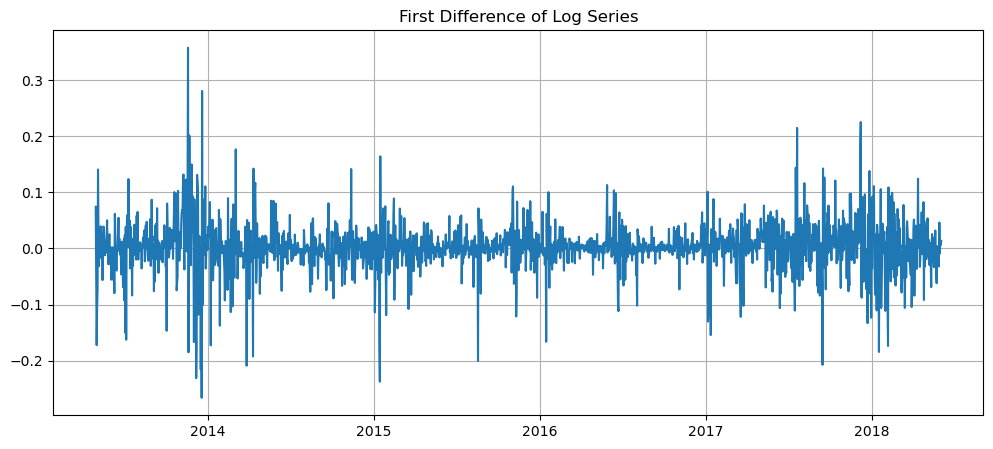

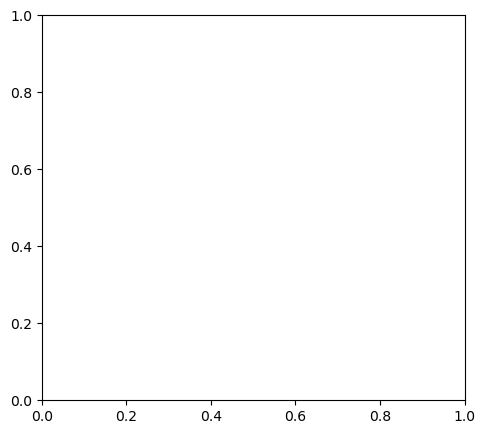

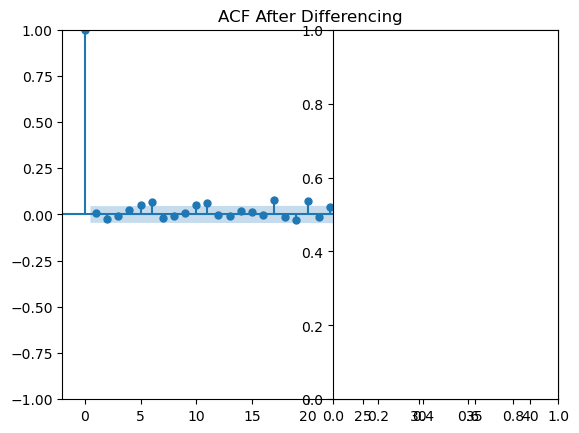

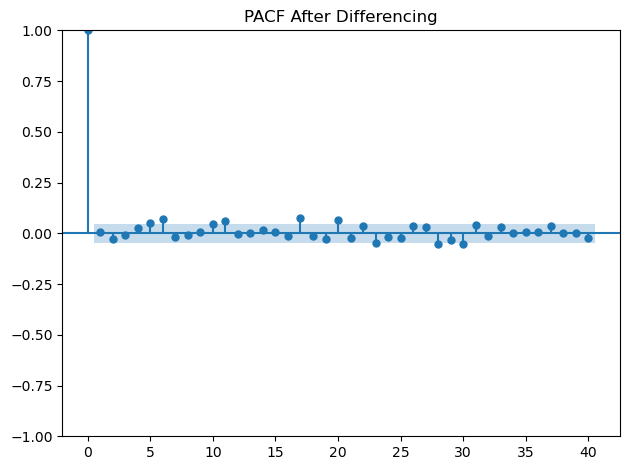

In [19]:
# ---------------------------
# Step 6 — Stationarity Check & Seasonal Decomposition
# ---------------------------

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt

# Use the Close time series you created earlier
close_ts = close_ts.asfreq('D').fillna(method='ffill')

# ---- 6.1 Rolling Mean & Std ----
plt.figure(figsize=(12,5))
plt.plot(close_ts, label='Original')
plt.plot(close_ts.rolling(30).mean(), label='30-day Mean')
plt.plot(close_ts.rolling(30).std(), label='30-day Std')
plt.legend()
plt.title("Rolling Mean & Std for BTC Close Price")
plt.grid(True)
plt.show()

# ---- 6.2 Log Transform ----
log_ts = np.log(close_ts)

plt.figure(figsize=(12,5))
plt.plot(log_ts)
plt.title("Log Transformed Close Price")
plt.grid(True)
plt.show()

# ---- 6.3 ADF Test ----
adf_result = adfuller(close_ts.dropna())
print("ADF Test on Original Series")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("-"*40)

# ---- 6.4 KPSS Test ----
kpss_stat, kpss_p, lags, crit = kpss(close_ts.dropna(), regression='c')
print("KPSS Test on Original Series")
print(f"KPSS Statistic: {kpss_stat}")
print(f"p-value: {kpss_p}")
print("-"*40)

# ---- 6.5 Seasonal Decomposition ----
decomp = seasonal_decompose(close_ts, model='multiplicative', period=365)
fig = decomp.plot()
fig.set_size_inches(14,8)
plt.show()

# ---- 6.6 First Difference ----
diff_ts = log_ts.diff().dropna()

plt.figure(figsize=(12,5))
plt.plot(diff_ts)
plt.title("First Difference of Log Series")
plt.grid(True)
plt.show()

# ---- 6.7 ACF / PACF ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(diff_ts, lags=40)
plt.title("ACF After Differencing")

plt.subplot(1,2,2)
plot_pacf(diff_ts, lags=40, method='ywm')
plt.title("PACF After Differencing")

plt.tight_layout()
plt.show()


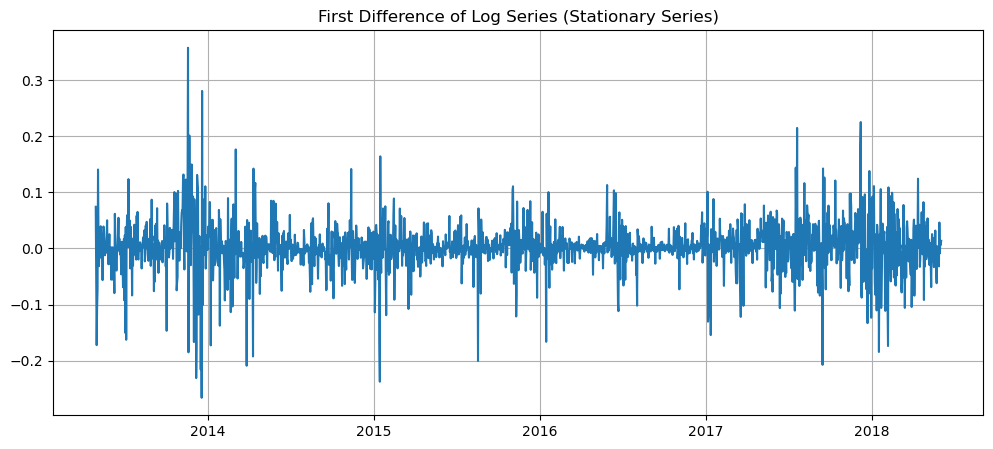

ADF After Differencing
ADF Statistic: -7.80005190001256
p-value: 7.535345555320197e-12
-----------------------------------


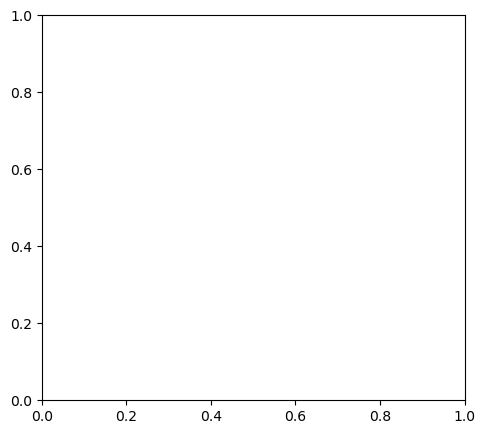

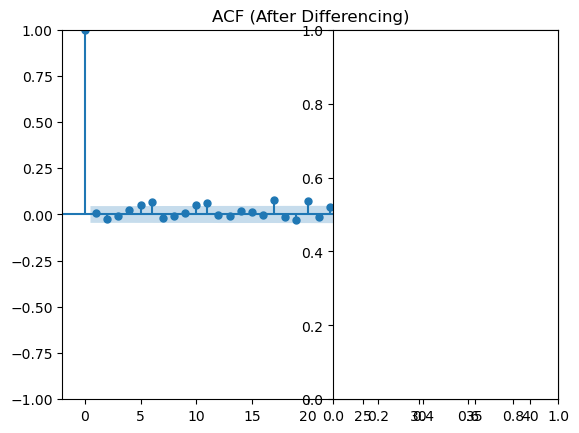

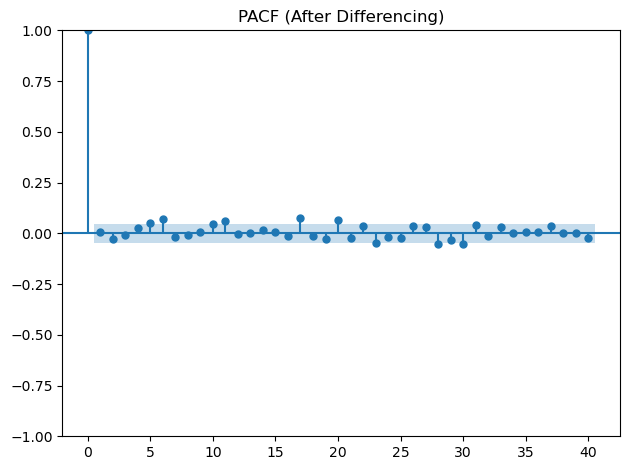

In [20]:
# Step 7 — Make Series Stationary (Log + Differencing)

# 1. Log transform
log_ts = np.log(close_ts)

# 2. First difference
diff_ts = log_ts.diff().dropna()

plt.figure(figsize=(12,5))
plt.plot(diff_ts)
plt.title("First Difference of Log Series (Stationary Series)")
plt.grid(True)
plt.show()

# 3. ADF test again (should be stationary now)
adf_after = adfuller(diff_ts)
print("ADF After Differencing")
print(f"ADF Statistic: {adf_after[0]}")
print(f"p-value: {adf_after[1]}")
print("-----------------------------------")

# 4. ACF & PACF for ARIMA order selection
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(diff_ts, lags=40)
plt.title("ACF (After Differencing)")

plt.subplot(1,2,2)
plot_pacf(diff_ts, lags=40, method='ywm')
plt.title("PACF (After Differencing)")

plt.tight_layout()
plt.show()


In [21]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(log_ts, order=(1,1,1))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1862
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3137.215
Date:                Sun, 16 Nov 2025   AIC                          -6268.431
Time:                        12:36:41   BIC                          -6251.844
Sample:                    04-28-2013   HQIC                         -6262.318
                         - 06-02-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1259      1.236     -0.102      0.919      -2.548       2.297
ma.L1          0.1376      1.237      0.111      0.911      -2.287       2.562
sigma2         0.0020      3e-05     66.924      0.0

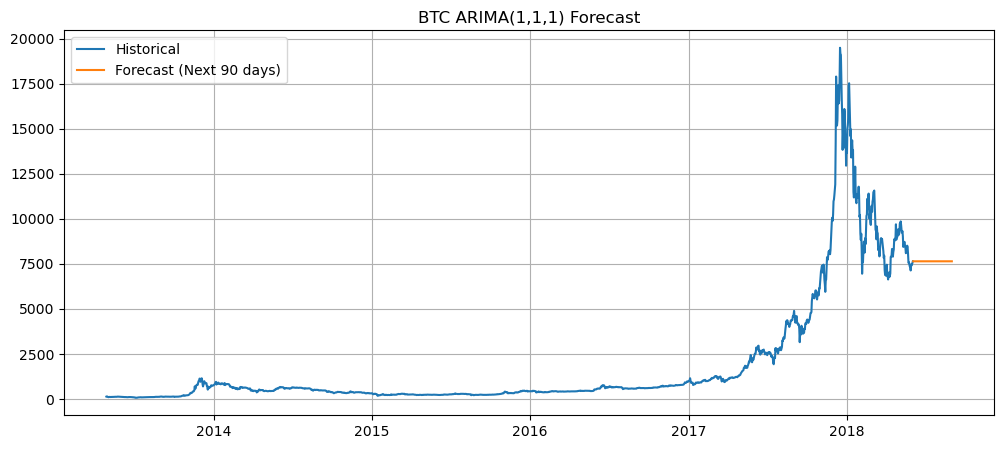

In [23]:
forecast = model_arima_fit.forecast(steps=90)
forecast = np.exp(forecast)  # inverse log

plt.figure(figsize=(12,5))
plt.plot(close_ts, label="Historical")
plt.plot(forecast, label="Forecast (Next 90 days)")
plt.legend()
plt.grid(True)
plt.title("BTC ARIMA(1,1,1) Forecast")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Use log_ts (already created earlier)
data = log_ts.dropna()

# Train-test split: last 20% for testing
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print("Train size:", len(train))
print("Test size:", len(test))

# Fit ARIMA on training data
model_arima = ARIMA(train, order=(1,1,1))
model_arima_fit = model_arima.fit()

# Forecast for length of test set
pred = model_arima_fit.forecast(steps=len(test))

# Convert back from log
pred_exp = np.exp(pred)
test_exp = np.exp(test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(test_exp, pred_exp))
mae = mean_absolute_error(test_exp, pred_exp)
mape = np.mean(np.abs((test_exp - pred_exp)/test_exp)) * 100

print("ARIMA(1,1,1) Evaluation on Test Set:")
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

# Plot comparison
plt.figure(figsize=(12,5))
plt.plot(test_exp.index, test_exp, label="Actual")
plt.plot(pred_exp.index, pred_exp, label="Predicted")
plt.title("ARIMA(1,1,1) — Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


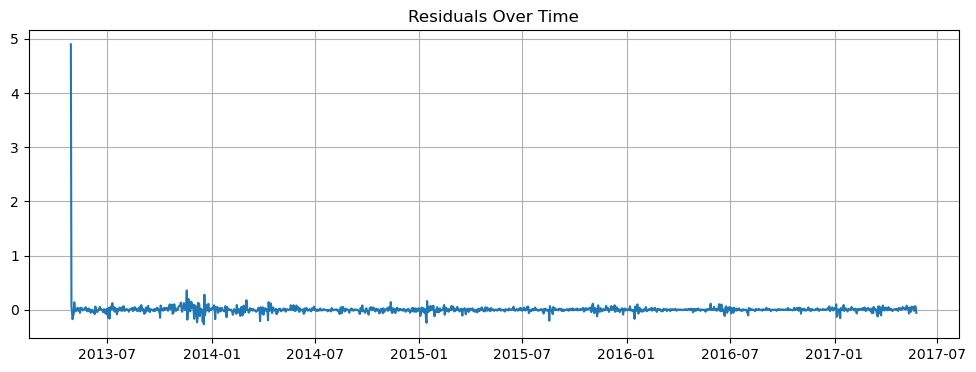

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


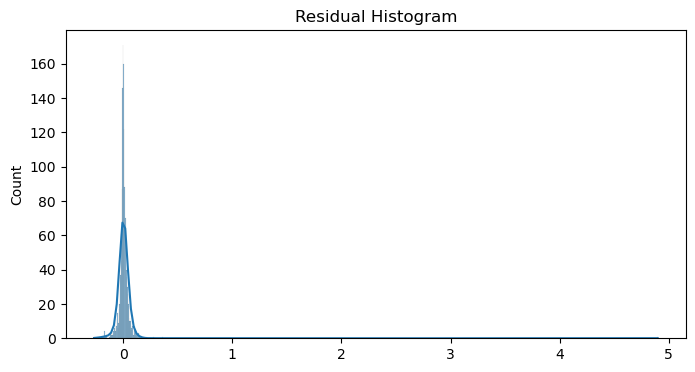

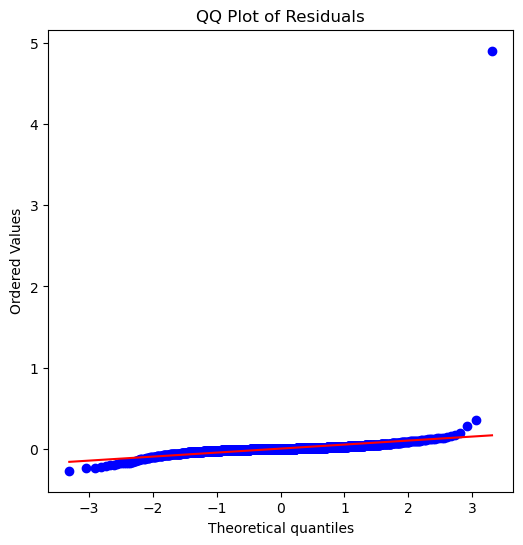

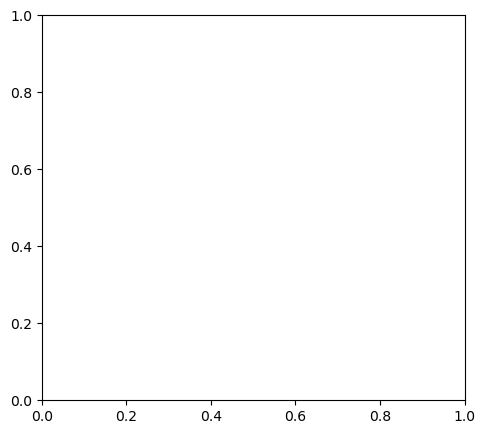

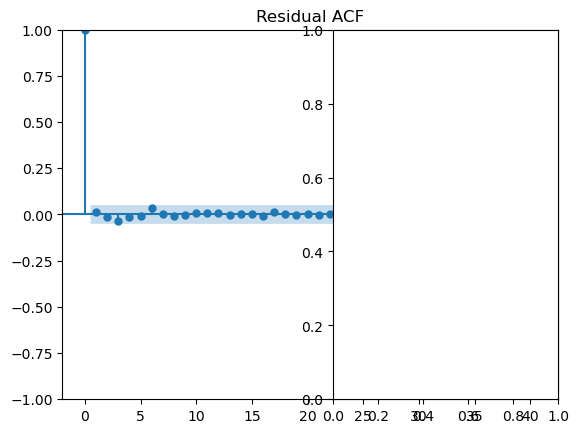

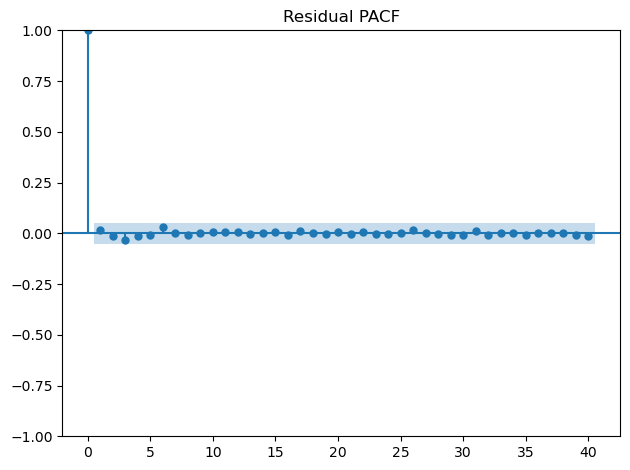

Ljung-Box Test:
     lb_stat  lb_pvalue
10  4.643304   0.913698


In [12]:
# Step 9 — ARIMA Residual Diagnostics

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

residuals = model_arima_fit.resid

# 1. Residual plot
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.grid(True)
plt.show()

# 2. Histogram
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Histogram")
plt.show()

# 3. QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

# 4. ACF and PACF of residuals
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(residuals, lags=40)
plt.title("Residual ACF")

plt.subplot(1,2,2)
plot_pacf(residuals, lags=40, method='ywm')
plt.title("Residual PACF")

plt.tight_layout()
plt.show()

# 5. Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(lb_test)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(
    log_ts,
    order=(1,1,1),
    seasonal_order=(1,1,1,365),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

sarima_forecast = sarima_fit.forecast(steps=90)
sarima_forecast = np.exp(sarima_forecast)  # invert log

plt.figure(figsize=(12,5))
plt.plot(close_ts, label="Historical")
plt.plot(sarima_forecast, label="SARIMA Forecast (Next 90 days)")
plt.title("BTC SARIMA(1,1,1)(1,1,1,365) Forecast")
plt.legend()
plt.grid(True)
plt.show()

# Train-test split
train, test = data[:train_size], data[train_size:]

sarima_train_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,365),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_train_fit = sarima_train_model.fit()

# Forecast on test
sarima_pred = sarima_train_fit.forecast(steps=len(test))

# Convert back from log
sarima_pred_exp = np.exp(sarima_pred)
test_exp = np.exp(test)

# Metrics
sarima_rmse = np.sqrt(mean_squared_error(test_exp, sarima_pred_exp))
sarima_mae = mean_absolute_error(test_exp, sarima_pred_exp)
sarima_mape = np.mean(np.abs((test_exp - sarima_pred_exp)/test_exp)) * 100

print("SARIMA Evaluation:")
print("RMSE:", sarima_rmse)
print("MAE:", sarima_mae)
print("MAPE:", sarima_mape)

# Plot
plt.figure(figsize=(12,5))
plt.plot(test_exp.index, test_exp, label="Actual")
plt.plot(sarima_pred_exp.index, sarima_pred_exp, label="Predicted")
plt.title("SARIMA — Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
import scipy.stats as stats

residuals = sarima_train_fit.resid.dropna()

# 1. Residual Plot
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("SARIMA Residuals")
plt.grid(True)
plt.show()

# 2. Histogram
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Histogram")
plt.show()

# 3. QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

# 4. ACF & PACF
plot_acf(residuals, lags=40)
plt.show()
plot_pacf(residuals, lags=40, method="ywm")
plt.show()

# 5. Ljung–Box Test
lb = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print(lb)



In [ ]:
import joblib
import pandas as pd

# Save model
joblib.dump(sarima_train_fit, "sarima_btc_model.pkl")

# Save forecast
out = pd.DataFrame({
    "test_actual": test_exp.values,
    "test_predicted": sarima_pred_exp.values
}, index=test_exp.index)

out.to_csv("sarima_test_results.csv")

print("Model + results saved.")


In [ ]:
import pandas as pd

comparison = pd.DataFrame({
    "Model": ["ARIMA(1,1,1)", "SARIMA(1,1,1)(1,1,1,365)"],
    "RMSE": [arima_rmse, sarima_rmse],
    "MAE":  [arima_mae, sarima_mae],
    "MAPE": [arima_mape, sarima_mape]
})

comparison


In [ ]:
from prophet import Prophet

df_p = df_symbol[["Date","Close"]].rename(columns={"Date":"ds","Close":"y"})

model_p = Prophet()
model_p.fit(df_p)

future = model_p.make_future_dataframe(periods=90)
forecast = model_p.predict(future)

model_p.plot(forecast)
plt.show()
